In [1]:
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import warnings
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

# Oil Price

In [3]:
import requests

api_key = '2LMFTJQ7V0USVG0B'

params = {
    'function': 'WTI',
    'interval': 'daily',
    'apikey': api_key
}

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=WTI&interval=monthly&apikey=demo'
r = requests.get(url, params=params)
data = r.json()

In [4]:
SP = pd.DataFrame(columns=['date', 'price'])
for i in range(len(data['data'])):
    SP.loc[i, 'date'] = data['data'][i]['date']
    SP.loc[i, 'price'] = data['data'][i]['value']
SP.index = pd.to_datetime(SP['date'])
SP.drop(columns='date', inplace=True)
SP.sort_index(inplace=True)
SP['price'] = pd.to_numeric(SP['price'], errors='coerce')
SP = SP.dropna()

In [5]:
CL = yf.download('CL=F', start='2000-08-23')
HO = yf.download('HO=F', start='2000-09-01')
RB = yf.download('RB=F', start='2000-11-01')
BZ = yf.download('BZ=F', start='2007-07-30')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
BZ_2 = pd.read_csv('Database/price_data/BZ_future.csv', index_col=0)
BZ_2.index = pd.to_datetime(BZ_2.index)
BZ_2_sorted = BZ_2.sort_index().loc[:'2007-07-22', ['Open', 'High', 'Low', 'Price']]
BZ_2_sorted['Adj Close'] = BZ_2_sorted['Price']
BZ_2_sorted = BZ_2_sorted.drop(columns=['Price'])
BL = pd.concat([BZ[['Open', 'High', 'Low', 'Adj Close']], BZ_2_sorted], axis=0).sort_index()
BL = pd.DataFrame(data=BL.values, columns=['Open', 'High', 'Low', 'Adj Close'], index=BL.index)

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent weekly price')

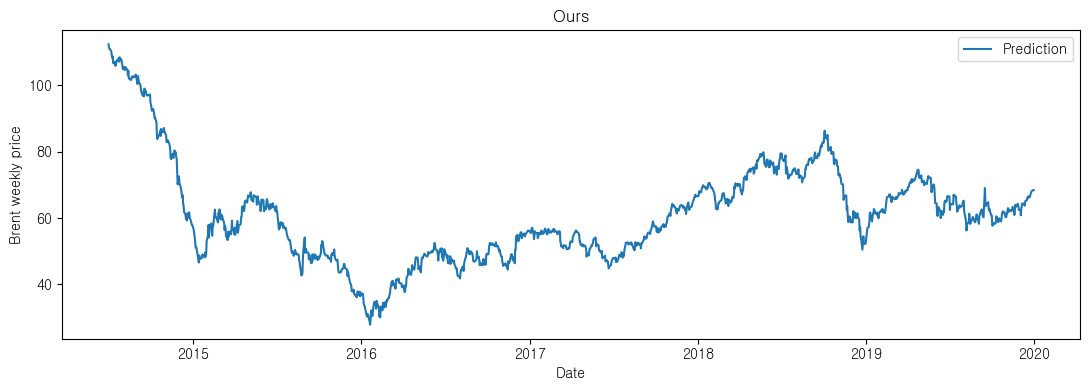

In [7]:
plt.figure(figsize=(11, 4))
plt.plot(BL.loc['2014-07-01':'2020-01-01', 'Adj Close'], label='Prediction')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent weekly price')
plt.legend()
plt.tight_layout()
plt.show()

# 1. Basic Variance

In [8]:
CL['return'] = CL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
HO['return'] = HO['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
RB['return'] = RB['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
BL['return'] = BL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
BL['return'] = BL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
SP['return'] = SP['price'].pct_change().apply(lambda x: np.log(1 + x))

In [9]:
CL_vol = (CL['return'] ** 2).rolling(window=20).sum().resample('W-FRI').mean().dropna()
HO_vol = (HO['return'] ** 2).rolling(window=20).sum().resample('W-FRI').mean().dropna()
RB_vol = (RB['return'] ** 2).rolling(window=20).sum().resample('W-FRI').mean().dropna()
BZ_vol = np.sqrt((BL['return'] ** 2).rolling(window=20).sum()).resample('W-FRI').mean().dropna()
SP_vol = np.sqrt((SP['return'] ** 2).rolling(window=20).sum()).resample('W-FRI').mean().dropna()

In [10]:
# CL_vol = CL['return'].rolling(window=20).std().resample('W-FRI').mean().dropna()
# HO_vol = HO['return'].rolling(window=20).std().resample('W-FRI').mean().dropna()
# RB_vol = RB['return'].rolling(window=20).std().resample('W-FRI').mean().dropna()
# BZ_vol2 = BL['return'].rolling(window=20).std().resample('W-FRI').mean().dropna()
# SP_vol2 = SP['return'].rolling(window=20).std().resample('W-FRI').mean().dropna()

# 2. Var(X)=E(X^2)

In [11]:
# CL_vol = (CL['return']**2).rolling(window=20).mean().resample('W-MON').mean().dropna()
# HO_vol = (HO['return']**2).rolling(window=20).mean().resample('W-MON').mean().dropna()
# RB_vol = (RB['return']**2).rolling(window=20).mean().resample('W-MON').mean().dropna()
# BZ_vol = (BL['return']**2).rolling(window=20).mean().resample('W-MON').mean().dropna()
# SP_vol = (SP['return']**2).rolling(window=20).mean().resample('W-MON').mean().dropna()

# 3.(이산 수익률-로그수익률)*2 의 평균 
(Scale을 논문과 맞추기 위해 일부로 2를 안해봄.)

In [12]:
# CL_log_r = CL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).dropna()
# HO_log_r = HO['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).dropna()
# RB_log_r = RB['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).dropna()
# BL_log_r = BL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).dropna()
# SP_log_r = SP['price'].pct_change().apply(lambda x: np.log(1 + x)).dropna()

# CL_r = CL['Adj Close'].pct_change().dropna()
# HO_r = HO['Adj Close'].pct_change().dropna()
# RB_r = RB['Adj Close'].pct_change().dropna()
# BL_r = BL['Adj Close'].pct_change().dropna()
# SP_r = SP['price'].pct_change().dropna()

# CL_vol = (CL_r - CL_log_r).rolling(window=5).mean().dropna()
# HO_vol = (HO_r - HO_log_r).rolling(window=5).mean().dropna()
# RB_vol = (RB_r - RB_log_r).rolling(window=5).mean().dropna()
# BZ_vol = (BL_r - BL_log_r).rolling(window=5).mean().dropna()
# SP_vol = (SP_r - SP_log_r).rolling(window=5).mean().dropna()

# CL_vol.name = 'return'
# HO_vol.name = 'return'
# RB_vol.name = 'return'
# BZ_vol.name = 'return'
# SP_vol.name = 'return'

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

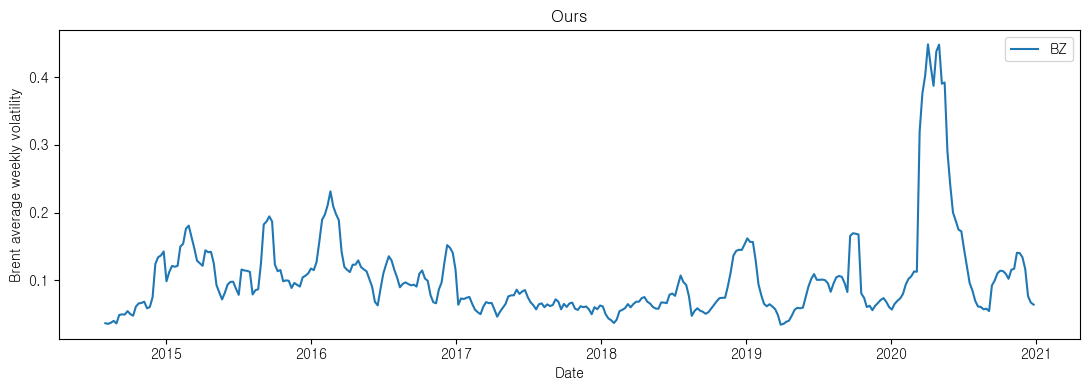

In [13]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
# plt.plot(SP_vol.loc['2014-08-01':'2020-12-31'], label='SP good')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
CL_vol.index = pd.to_datetime(CL_vol.index)
HO_vol.index = pd.to_datetime(HO_vol.index)
RB_vol.index = pd.to_datetime(RB_vol.index)
BZ_vol.index = pd.to_datetime(BZ_vol.index)
SP_vol.index = pd.to_datetime(SP_vol.index)
vol_list = [CL_vol, HO_vol, RB_vol, BZ_vol, SP_vol]

# Dow Jones

In [15]:
DJ_idx = yf.download('^DJI', start='1986-01-01')
DJ = pd.read_csv('Database/price_data/Dow_Jones.csv')

[*********************100%%**********************]  1 of 1 completed


In [16]:
DJ_idx = DJ_idx['Adj Close'].loc['2007-04-03':].resample('W-FRI').last()
DJ.index = DJ['date']
DJ.index = pd.to_datetime(DJ.index)
DJ = DJ['dji'].resample('W-FRI').last()
DJ = pd.concat([DJ_idx, DJ], axis=0)
DJ.sort_index(inplace=True)
DJ.name = 'Dow Jones'

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

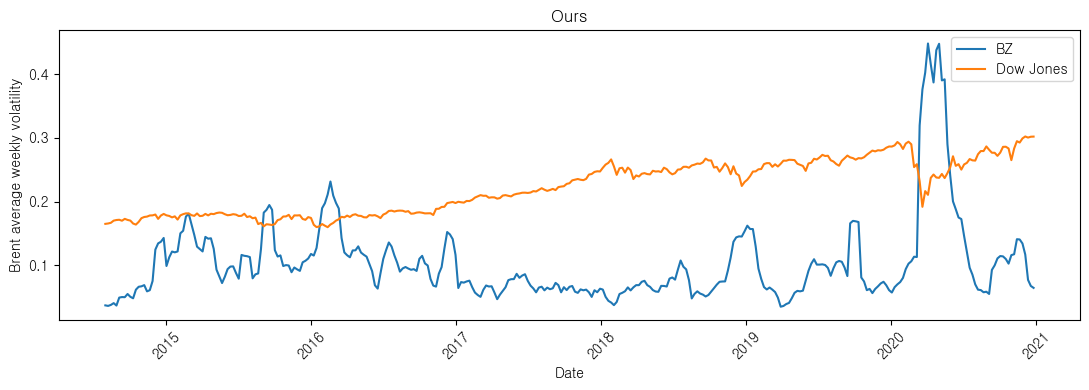

In [17]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(DJ.loc['2014-08-01':'2020-12-31'] / 100000, label='Dow Jones')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# S&P500

In [128]:
SP_idx = yf.download('^GSPC', start='1986-01-01')

[*********************100%%**********************]  1 of 1 completed


In [129]:
SP_idx = SP_idx['Adj Close'].resample('W-FRI').last()
SP_idx.name = 'S&P500'

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

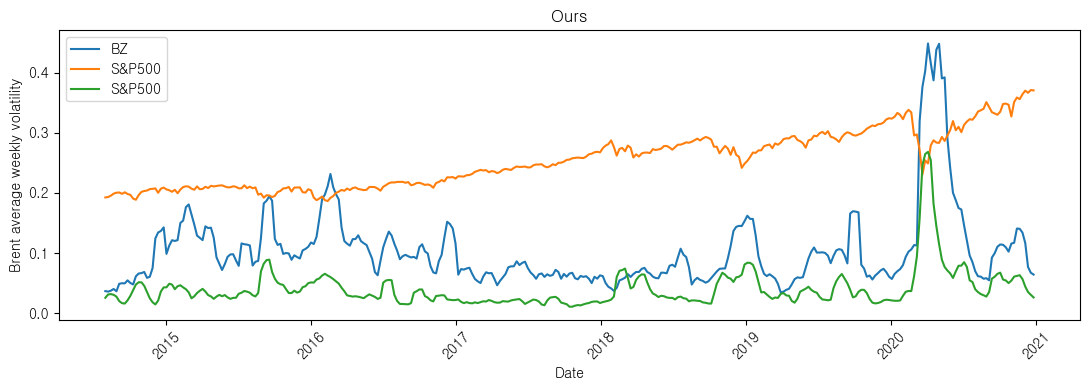

In [130]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(SP_idx.loc['2014-08-01':'2020-12-31'] / 10000, label='S&P500')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# GDP

In [21]:
GDP = pd.read_csv('Database/price_data/GDP.csv', index_col=0)

In [22]:
weekly_df = GDP.asfreq('D')  # 주간 빈 날짜를 생성
weekly_df.loc[GDP.index] = GDP.values
weekly_df['GDP'] = weekly_df['GDP'].interpolate(method='linear')  # 선형 보간법 적용

GDP = weekly_df['GDP'].resample('W-FRI').last()
GDP.name = 'GDP'

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

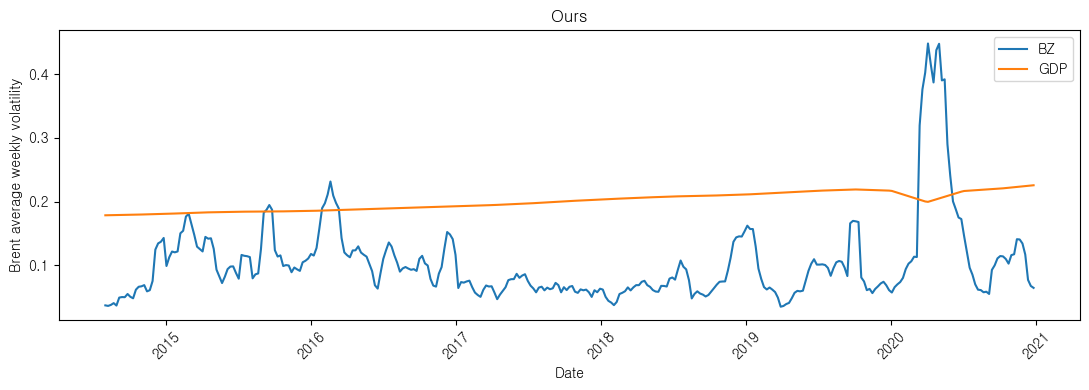

In [23]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(GDP.loc['2014-08-01':'2020-12-31'] / 100000, label='GDP')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# CPI

In [24]:
CPI = pd.read_csv('Database/price_data/CPI_fuel.csv', index_col=0)

In [25]:
weekly_df = CPI.asfreq('D')  # 주간 빈 날짜를 생성
weekly_df.loc[CPI.index] = CPI.values
weekly_df['CUSR0000SEHE'] = weekly_df['CUSR0000SEHE'].interpolate(method='linear')  # 선형 보간법 적용
CPI = weekly_df['CUSR0000SEHE'].resample('W-FRI').last()
CPI.name = 'CPI'

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

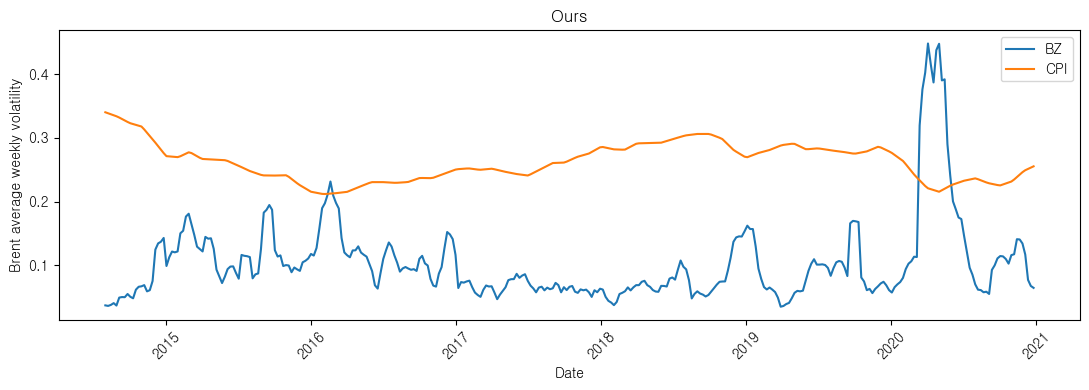

In [26]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(CPI.loc['2014-08-01':'2020-12-31'] / 1000, label='CPI')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inflation

In [27]:
IF = pd.read_csv('Database/price_data/Ex_inflation_y.csv', index_col=0)

In [28]:
weekly_df = IF.asfreq('D')  # 주간 빈 날짜를 생성
weekly_df.loc[IF.index] = IF.values
weekly_df['EXPINF1YR'] = weekly_df['EXPINF1YR'].interpolate(method='linear')  # 선형 보간법 적용
IF = weekly_df['EXPINF1YR'].resample('W-FRI').last()
IF.name = 'Inflation'

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

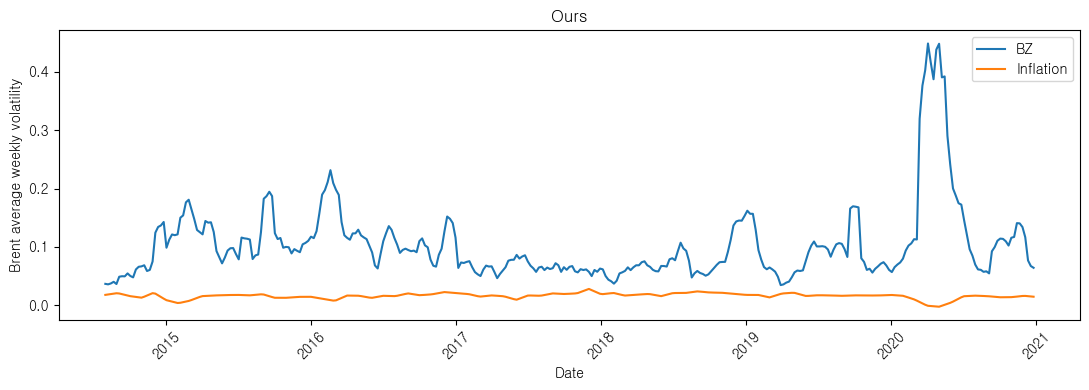

In [29]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(IF.loc['2014-08-01':'2020-12-31'] / 100, label='Inflation')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# BDI

In [30]:
BDI = pd.read_csv('Database/price_data/BDI_w.csv')

In [31]:
BDI.index = BDI['날짜']
BDI = BDI['종가'].str.replace(',', '').astype(float)
BDI.index = pd.to_datetime(BDI.index)
BDI = BDI.sort_index()
BDI.name = 'BDI'
BDI = BDI.drop('1986-01-05')

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

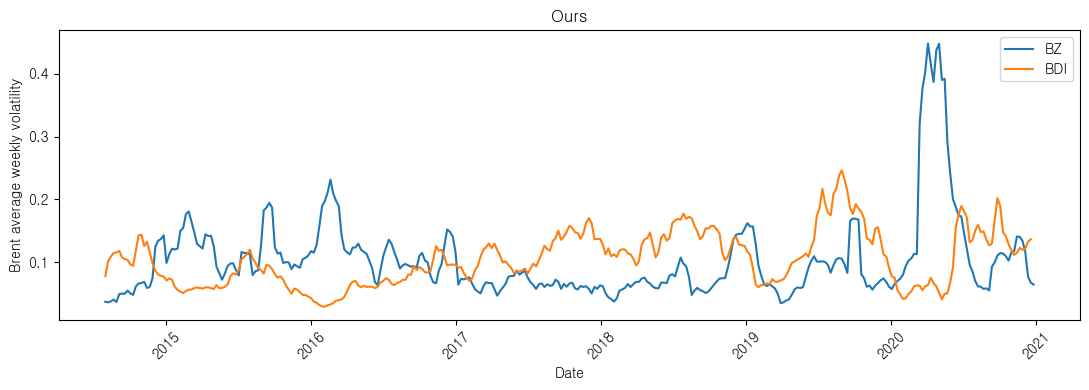

In [147]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(BDI.loc['2014-08-01':'2020-12-31'] / 10000, label='BDI')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Treasure Yield

In [33]:
import requests

api_key = 'AJPT9SW0WL4NNYHN'

url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'

params = {
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '30year',
    'apikey': api_key
}

r = requests.get(url, params=params)
yield_30 = r.json()

In [34]:
import requests

api_key = 'AJPT9SW0WL4NNYHN'

url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'

params = {
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '7year',
    'apikey': api_key
}

r = requests.get(url, params=params)
yield_7 = r.json()

In [35]:
import requests

api_key = 'AJPT9SW0WL4NNYHN'

url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'

params = {
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '3month',
    'apikey': api_key
}

r = requests.get(url, params=params)
yield_3m = r.json()

In [36]:
yield_30_df = pd.DataFrame(columns=['date', '30_yield'])
for i in range(len(yield_30['data'])):
    yield_30_df.loc[i, 'date'] = yield_30['data'][i]['date']
    yield_30_df.loc[i, '30_yield'] = yield_30['data'][i]['value']
yield_30_df.set_index(yield_30_df['date'], inplace=True)
yield_30_df.index = pd.to_datetime(yield_30_df.index)
yield_30_df = yield_30_df.drop(columns=['date'])
yield_30_df['30_yield'] = yield_30_df['30_yield'].str.replace('.', '').replace('', np.nan)
yield_30_df.dropna(subset=['30_yield'], inplace=True)
yield_30_df['30_yield'] = yield_30_df['30_yield'].astype(float)

In [37]:
yield_7_df = pd.DataFrame(columns=['date', '7_yield'])
for i in range(len(yield_7['data'])):
    yield_7_df.loc[i, 'date'] = yield_7['data'][i]['date']
    yield_7_df.loc[i, '7_yield'] = yield_7['data'][i]['value']
yield_7_df.set_index(yield_7_df['date'], inplace=True)
yield_7_df.index = pd.to_datetime(yield_7_df.index)
yield_7_df = yield_7_df.drop(columns=['date'])
yield_7_df['7_yield'] = yield_7_df['7_yield'].str.replace('.', '').replace('', np.nan)
yield_7_df.dropna(subset=['7_yield'], inplace=True)
yield_7_df['7_yield'] = yield_7_df['7_yield'].astype(float)

In [38]:
yield_3m_df = pd.DataFrame(columns=['date', '3m_yield'])
for i in range(len(yield_3m['data'])):
    yield_3m_df.loc[i, 'date'] = yield_3m['data'][i]['date']
    yield_3m_df.loc[i, '3m_yield'] = yield_3m['data'][i]['value']
yield_3m_df.set_index(yield_3m_df['date'], inplace=True)
yield_3m_df.index = pd.to_datetime(yield_3m_df.index)
yield_3m_df = yield_3m_df.drop(columns=['date'])
yield_3m_df['3m_yield'] = yield_3m_df['3m_yield'].str.replace('.', '').replace('', np.nan)
yield_3m_df.dropna(subset=['3m_yield'], inplace=True)
yield_3m_df['3m_yield'] = yield_3m_df['3m_yield'].astype(float)

In [39]:
yield_3m_df = yield_3m_df.resample('W-FRI').last()
yield_7_df = yield_7_df.resample('W-FRI').last()
yield_30_df = yield_30_df.resample('W-FRI').last()

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

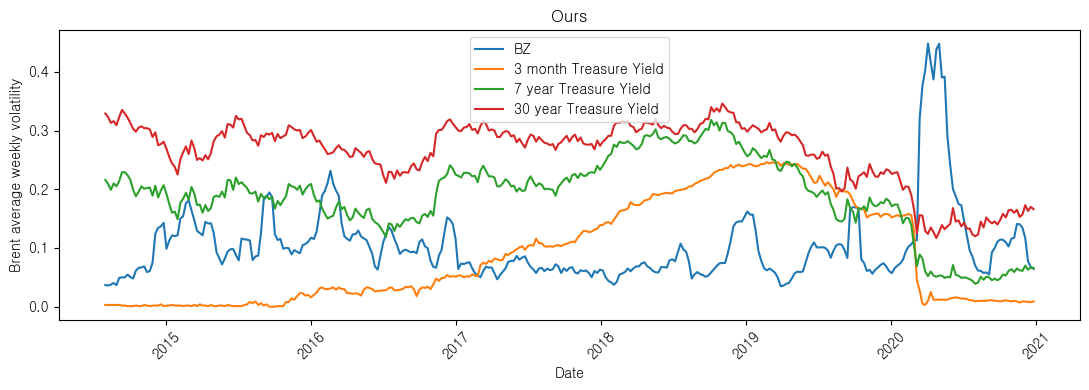

In [146]:
plt.figure(figsize=(11, 4))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.plot(yield_3m_df.loc['2014-08-01':'2020-12-31'] / 1000, label='3 month Treasure Yield')
plt.plot(yield_7_df.loc['2014-08-01':'2020-12-31'] / 1000, label='7 year Treasure Yield')
plt.plot(yield_30_df.loc['2014-08-01':'2020-12-31'] / 1000, label='30 year Treasure Yield')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# GARCH

In [41]:
CV = pd.read_csv('Database/price_data/sp_return_1_conditional_vol.csv', index_col=0)
CV2 = pd.read_csv('Database/price_data/sp_return_2_conditional_vol.csv', index_col=0)
CV3 = pd.read_csv('Database/price_data/sp_return_3_conditional_vol.csv', index_col=0)
CV.index = pd.DatetimeIndex(CV.index)
CV2.index = pd.DatetimeIndex(CV2.index)
CV3.index = pd.DatetimeIndex(CV3.index)

<Figure size 1100x400 with 0 Axes>

Text(0.5, 1.0, 'Ours')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Brent average weekly volatility')

(array([12600., 12692., 12784., 12874., 12965., 13057., 13149., 13239.,
        13330., 13422., 13514.]),
 [Text(12600.0, 0, '2004-07'),
  Text(12692.0, 0, '2004-10'),
  Text(12784.0, 0, '2005-01'),
  Text(12874.0, 0, '2005-04'),
  Text(12965.0, 0, '2005-07'),
  Text(13057.0, 0, '2005-10'),
  Text(13149.0, 0, '2006-01'),
  Text(13239.0, 0, '2006-04'),
  Text(13330.0, 0, '2006-07'),
  Text(13422.0, 0, '2006-10'),
  Text(13514.0, 0, '2007-01')])

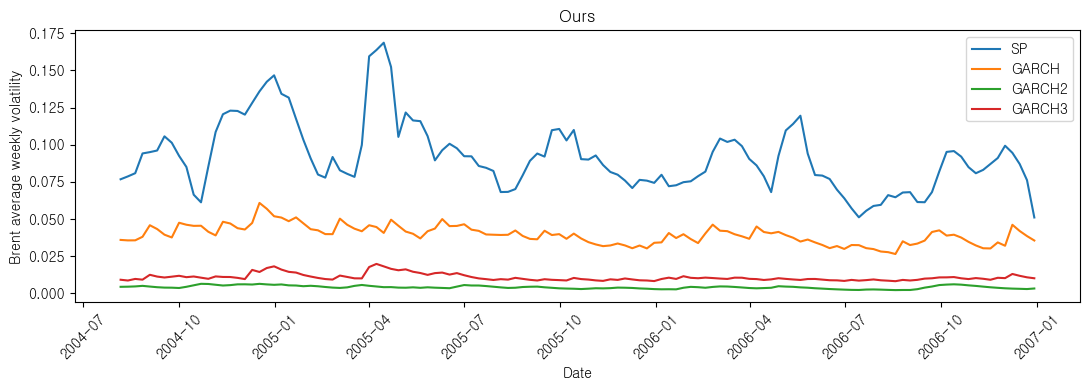

In [42]:
plt.figure(figsize=(11, 4))
plt.plot(SP_vol.loc['2004-08-01':'2006-12-31'], label='SP')
plt.plot(CV.loc['2004-08-01':'2006-12-31'], label='GARCH')
plt.plot(CV2.loc['2004-08-01':'2006-12-31'], label='GARCH2')
plt.plot(CV3.loc['2004-08-01':'2006-12-31'], label='GARCH3')
plt.title('Ours')
plt.xlabel('Date')
plt.ylabel('Brent average weekly volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 외생변수 전처리

In [43]:
start_date = '1986-01-06'
end_date = '2024-04-29'
test = yield_7_df.loc[start_date:end_date]
date_idx = list(test.index)

In [44]:
from datetime import timedelta

# 주어진 날짜 리스트
dates = [
    pd.Timestamp('1999-12-26'),
    pd.Timestamp('2004-12-26'),
    pd.Timestamp('2005-12-25'),
    pd.Timestamp('2006-12-24'),
    pd.Timestamp('2009-12-27'),
    pd.Timestamp('2010-12-26'),
    pd.Timestamp('2011-12-25'),
    pd.Timestamp('2015-12-27'),
    pd.Timestamp('2016-12-25'),
    pd.Timestamp('2017-12-24'),
    pd.Timestamp('2020-12-27'),
    pd.Timestamp('2021-12-26'),
    pd.Timestamp('2022-12-25'),
    pd.Timestamp('2023-12-24')
]

# 하루를 더한 날짜를 저장할 리스트
dates_plus_one = []

# 각 날짜에 하루를 더해서 리스트에 추가
for date in dates:
    new_date = date - timedelta(days=2)
    dates_plus_one.append(new_date)

In [45]:
date_idx = [p for p in date_idx if p not in dates_plus_one]
BDI.index = date_idx

In [46]:
exterior = pd.concat([DJ, SP_idx, GDP, CPI, IF, BDI, yield_30_df, yield_3m_df, yield_7_df], axis=1)
exterior = exterior.loc['1986-01-10':'2024-01-05'].ffill()
exterior.to_csv('Database/price_data/exterior.csv')

# Sentiment

In [47]:
# df = pd.read_parquet('Database/sentiment.parquet')
# df.index=df['date']
# semtiment_idx=df['sentiment']
# test = pd.concat([vol_list[4], semtiment_idx], axis=1)
# test = test.loc[:'2001-12-30']
# mask = (test['return'].isna() == False) & (test['sentiment'].isna() == True)
# # test.loc[mask, '0':] = 0
# print(test[mask].shape[0])
# i=0
# while test[mask].shape[0] > 0:
#     i+=1
#     previous_values = test.shift(-i)
#     masked_previous_values = previous_values[mask]
#     test.loc[mask, 'sentiment'] = masked_previous_values.loc[:, 'sentiment']
#     mask = (test['return'].isna() == False) & (test['sentiment'].isna() == True)
#     print(test[mask].shape[0])
# test = test.dropna(subset=['return'])

# test.loc[test.index[test.isna().any(axis=1)], '0':] = new_df.loc['2000-01-03'].values

# Text Data Preprocessing

In [104]:
text_data = pd.read_parquet('Database/newsdata.parquet')

NLP_vec = text_data[['date', 'embeddings']].reset_index()
NLP_vec.index = NLP_vec['date']
NLP_vec = NLP_vec['embeddings']

new_columns = {f'{i}': pd.Series(dtype='object') for i in range(384)}
new_df = pd.DataFrame(new_columns)

for i in range(384):
    new_df[f'{i}'] = NLP_vec.apply(lambda x: f'{x[i]}')

In [107]:
test = pd.concat([exterior, new_df], axis=1)
test = test.loc[:'2001-12-30']
mask = (test['Dow Jones'].isna() == False) & (test['0'].isna() == True)
print(test[mask].shape[0])
i = 0
while test[mask].shape[0] > 0:
    i += 1
    previous_values = test.shift(-i)
    masked_previous_values = previous_values[mask]
    test.loc[mask, '0':] = masked_previous_values.loc[:, '0':]
    mask = (test['Dow Jones'].isna() == False) & (test['0'].isna() == True)
    print(test[mask].shape[0])
test = test.dropna(subset=['Dow Jones'])

317
2
0


In [108]:
test.index[test.isna().any(axis=1)]

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

# Exterior (+ NLP) -> Min Max Scaler

In [163]:
test = pd.read_csv('Database/price_data/exterior.csv', index_col=0)
test.index = pd.DatetimeIndex(test.index)

In [164]:
concat_list = []
for i, vol in enumerate(vol_list):
    concat_list.append(pd.concat([vol, test[['Dow Jones']]], axis=1))
    concat_list[i] = concat_list[i].dropna()

In [165]:
from joblib import dump
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in range(5):
    scaled_values = scaler.fit_transform(concat_list[i])
    scaled_test = pd.DataFrame(scaled_values, columns=concat_list[i].columns, index=concat_list[i].index)
    concat_list[i] = scaled_test
    dump(scaler, f'scaler_{i}.joblib')
    print("Scaler object saved successfully!")

['scaler_0.joblib']

Scaler object saved successfully!


['scaler_1.joblib']

Scaler object saved successfully!


['scaler_2.joblib']

Scaler object saved successfully!


['scaler_3.joblib']

Scaler object saved successfully!


['scaler_4.joblib']

Scaler object saved successfully!


In [102]:
# from sklearn.decomposition import PCA
# 
# # Kernel PCA 모델 생성
# pca = PCA(n_components=0.99)
# 
# # Kernel PCA 적합 및 변환
# X_pca = pca.fit_transform(scaled_test.iloc[:, 1:])
# pca_df = pd.DataFrame(data=X_pca, columns=[f'PCA_{i + 1}' for i in range(X_pca.shape[1])], index=scaled_test.index)
# scaled_test = pd.concat([scaled_test.iloc[:, 0], pca_df], axis=1)

In [144]:
vol_list[3].loc['2008-05-23':]

Date
2008-05-23    0.086907
2008-05-30    0.092609
2008-06-06    0.095015
2008-06-13    0.125078
2008-06-20    0.124070
                ...   
2024-04-12    0.051212
2024-04-19    0.048768
2024-04-26    0.050417
2024-05-03    0.061643
2024-05-10    0.067870
Name: return, Length: 833, dtype: float64

# Save Files

In [158]:
name_list = ['CL_vol', 'HO_vol', 'RB_vol', 'BZ_vol', 'SP_vol']
for i, vol in enumerate(name_list):
    if i != 4:
        vol_list[i].to_csv(f'Database/future_std/{vol}.csv')
    else:
        vol_list[i].to_csv(f'Database/spot_std/{vol}.csv')

In [166]:
name_list = ['CL_vol', 'HO_vol', 'RB_vol', 'BZ_vol', 'SP_vol']
for i, vol in enumerate(name_list):
    if i != 4:
        concat_list[i].to_csv(f'Database/future_std/{vol}.csv')
    else:
        concat_list[i].to_csv(f'Database/spot_std/{vol}.csv')